In [38]:
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from keras.callbacks import Callback
from keras.utils import array_to_img
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout
from keras.activations import tanh
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.models import Model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)
tf.config.run_functions_eagerly(True)

import warnings
warnings.filterwarnings('ignore')

In [39]:
pv_year = pd.read_csv('hourly.csv')[['Month', 'Day', 'Hour', 'DC Output (W)']]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for m in range(1, 13):
    mask = pv_year['Month'] == m
    to_save = {}
    for t in range(int(len(pv_year[mask]['DC Output (W)'])/24)):
        to_save[t] = np.divide(pv_year[mask]['DC Output (W)'].iloc[t*24:(t+1)*24].values, 1000)
    counter = 1
    while counter <= 30:
        c1 = random.choice(list(to_save.keys()))
        c2 = random.choice(list(to_save.keys()))
        while True:
            if c2 == c1:
                c2 = random.choice(list(to_save.keys()))
            else:
                break
        to_save[f'g{counter}'] = np.divide(to_save[c1] + to_save[c2], 2)
        counter += 1
    pd.DataFrame(to_save).to_csv(f'PV-{months[m-1]}.csv')

In [55]:
month_name='Dec'
my_data = pd.read_csv(f'PV-{month_name}.csv')
ds = []
for c in my_data.columns[1:]:
        ds.append([my_data[c].values])
max = np.max(ds)
ds = np.divide(ds, max)

### Prepare data to feed into GAN

In [56]:
ds = tf.data.Dataset.from_tensor_slices(ds)
batch_size = 5
ds = ds.cache()
ds = ds.shuffle(1000)
ds = ds.batch(batch_size)
ds = ds.prefetch(64)

## Generator Discriminator Training

In [57]:
'''Generator'''
g_relu = 0.2
def build_generator():
    model = Sequential()

    model.add(Dense(1*24*batch_size, input_dim=batch_size))
    model.add(LeakyReLU(g_relu))
    model.add(Reshape((1,24, batch_size)))

    #model.add(UpSamplingD())
    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(batch_size, 3, padding='same'))
    model.add(LeakyReLU(g_relu))

    model.add(Conv2D(1, 3, padding='same', activation='sigmoid'))
    return model
generator = build_generator()


'''Discriminator'''
d_relu = 0.2
d_dropout = 0.2
def build_discriminator():
    model = Sequential()

    model.add(Dense(200, input_shape=(1, 24, 1)))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Dense(150))
    model.add(LeakyReLU(d_relu))
    model.add(Dropout(d_dropout))

    model.add(Flatten())
    model.add(Dropout(d_dropout))
    model.add(Dense(1, activation='sigmoid'))
    # 1: fake series, 0: real series

    return model
discriminator = build_discriminator()

'''Train'''
g_a, d_a = 0.0001, 0.00001
g_opt = Adam(learning_rate=g_a)
d_opt = Adam(learning_rate=d_a)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((batch_size, batch_size, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
loadgan = LoadGAN(generator, discriminator)
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [10]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=batch_size):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= max
        generated_series.numpy()
        for i in range(self.num_img):
            serie = array_to_img(generated_series[i])

#### Train

In [58]:
hist = loadgan.fit(ds, epochs=500)

Epoch 1/500
13/13 [==============================] - 2s 146ms/step - d_loss: 0.6961 - g_loss: 0.6704
Epoch 2/500
13/13 [==============================] - 2s 150ms/step - d_loss: 0.6924 - g_loss: 0.6759
Epoch 3/500
13/13 [==============================] - 2s 142ms/step - d_loss: 0.6930 - g_loss: 0.6814
Epoch 4/500
13/13 [==============================] - 2s 141ms/step - d_loss: 0.6887 - g_loss: 0.6869
Epoch 5/500
13/13 [==============================] - 2s 134ms/step - d_loss: 0.6854 - g_loss: 0.6926
Epoch 6/500
13/13 [==============================] - 2s 118ms/step - d_loss: 0.6849 - g_loss: 0.6984
Epoch 7/500
13/13 [==============================] - 2s 118ms/step - d_loss: 0.6760 - g_loss: 0.7042
Epoch 8/500
13/13 [==============================] - 2s 118ms/step - d_loss: 0.6769 - g_loss: 0.7101
Epoch 9/500
13/13 [==============================] - 2s 117ms/step - d_loss: 0.6690 - g_loss: 0.7160
Epoch 10/500
13/13 [==============================] - 2s 117ms/step - d_loss: 0.6700 - g_lo

1/1 [==============================] - 0s 36ms/step


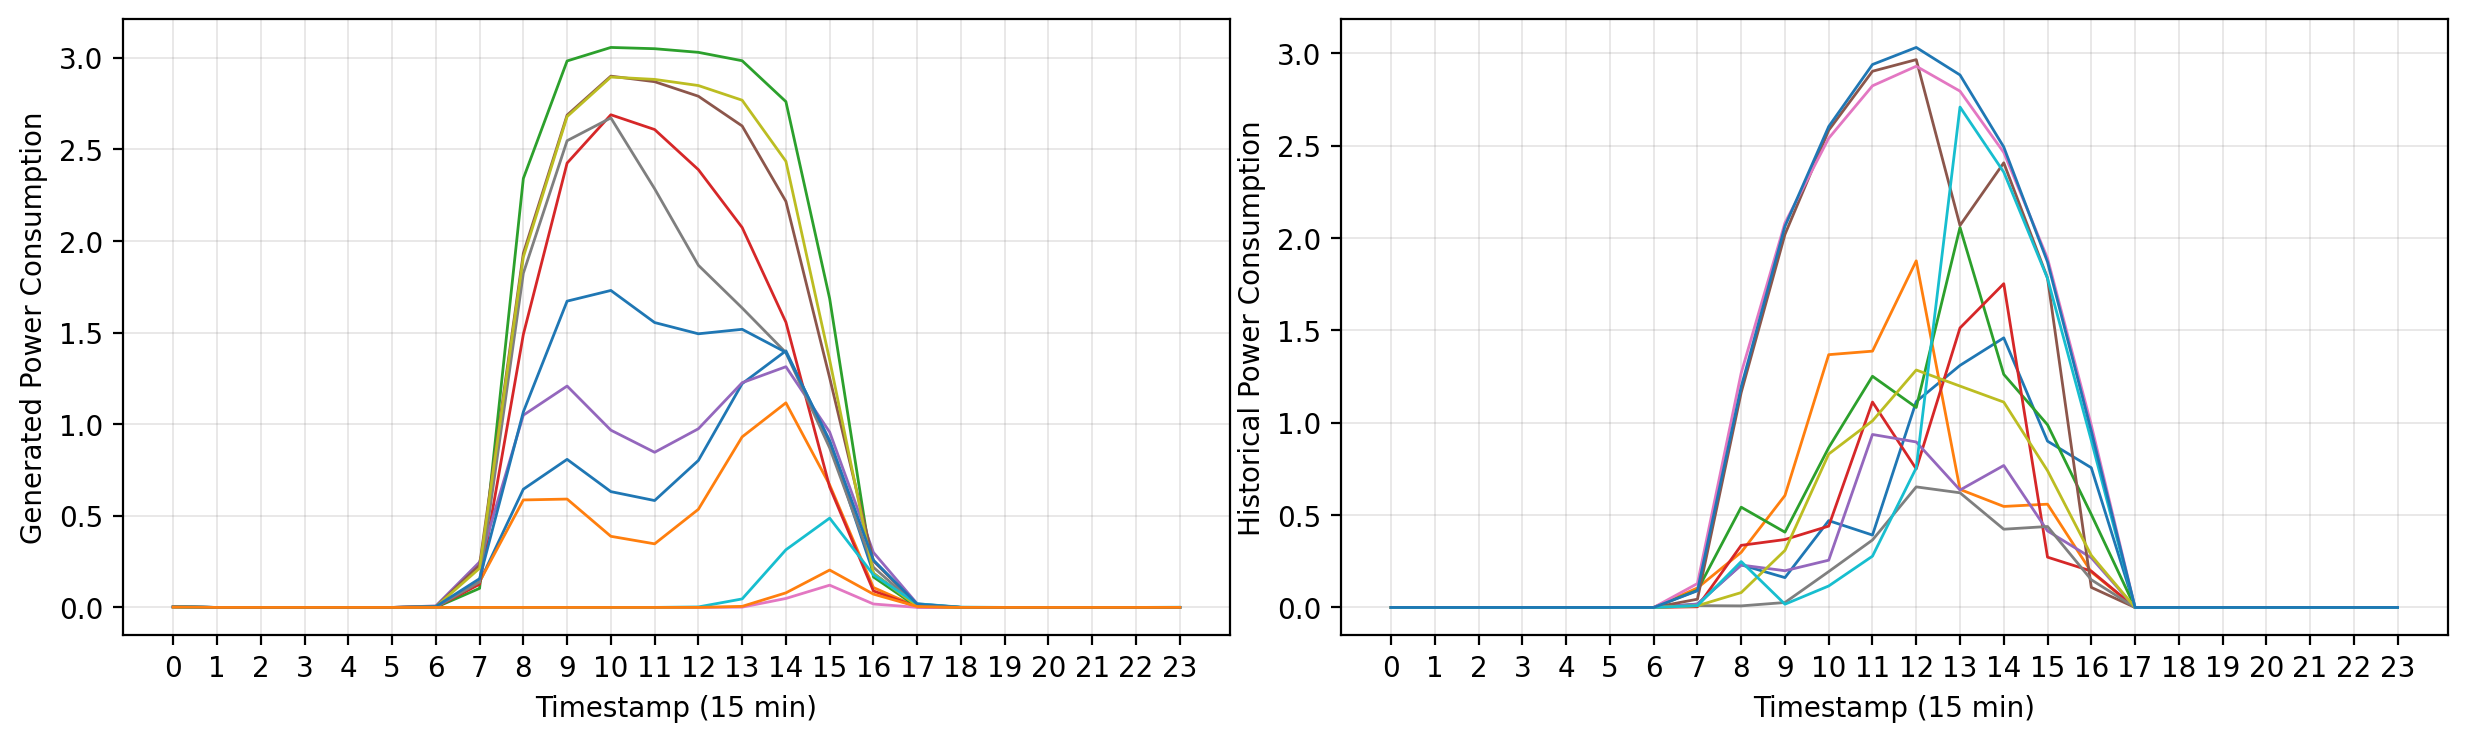

In [59]:
if True:
    scenario_size = 30
    normal_noise = tf.random.normal((scenario_size, batch_size, 1))
    n = [np.random.normal() for _ in range(scenario_size)]
    series = np.multiply(generator.predict(normal_noise), max)
    resolution = 24

    probabilities = []
    ranges = np.linspace(-3.5, 3.5, 8)
    intervals = np.linspace(-3, 3, 7)
    probs = [stats.norm.cdf(i) for i in n]
    prob_ranges = {intervals[i]: [stats.norm.cdf(ranges[i]), stats.norm.cdf(ranges[i+1])] for i in range(len(intervals))}
    for i in probs:
        for key in intervals:
            if prob_ranges[key][0]<= i <=prob_ranges[key][1]:
                probabilities.append(prob_ranges[key][1]-prob_ranges[key][0])
                break
    scenarios = {'probs': probabilities}
    for j in range(resolution):
        scenarios[j] = []
    for i in range(scenario_size):
        s = series[i].reshape([resolution])
        for j in range(resolution):
            scenarios[j].append(s[j])
pd.DataFrame(scenarios).to_csv(f'PVscenario-{month_name}.csv')
if True:
    ticks = [i for i in range(resolution)]
    fig, ax = plt.subplots(1, 2, figsize=(15, 4), dpi=200)
    for s in series[:12]:
        ax[0].plot(range(resolution), s.reshape([resolution]), linewidth=1)
    ax[0].set_xlabel('Timestamp (15 min)')
    ax[0].set_ylabel('Generated Power Consumption')
    ax[0].set_xticks(ticks, ticks)
    ax[0].grid(color='#666362', linestyle='-', linewidth=0.1)

    ax[1].plot(my_data[[c for c in my_data.columns][4:15]], linewidth=1)
    ax[1].set_xlabel('Timestamp (15 min)')
    ax[1].set_ylabel('Historical Power Consumption')
    ax[1].set_xticks(ticks, ticks)
    ax[1].grid(color='#666362', linestyle='-', linewidth=0.1)
    plt.subplots_adjust(wspace=0.1)
#plt.savefig(f'PV GAN {month_name}.jpg', bbox_inches='tight')

### Save models

In [48]:
'''plt.figure(figsize=(7, 3), dpi=300)
plt.plot(hist.history['d_loss'], label='Generator Loss')
plt.plot(hist.history['g_loss'], label='Discriminator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(color='#666362', linestyle='-', linewidth=0.1)
plt.savefig(f'IMG/{month_name}-{day_type}-loss.jpg', bbox_inches='tight')'''

"plt.figure(figsize=(7, 3), dpi=300)\nplt.plot(hist.history['d_loss'], label='Generator Loss')\nplt.plot(hist.history['g_loss'], label='Discriminator Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss Value')\nplt.legend()\nplt.grid(color='#666362', linestyle='-', linewidth=0.1)\nplt.savefig(f'IMG/{month_name}-{day_type}-loss.jpg', bbox_inches='tight')"